<a href="https://colab.research.google.com/github/ericsungtwn/myrepo/blob/master/02_DeepLearning_without_framework_BP_method_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create network by layers and use gradient descent with computation graph (Backprop, BP)




In [1]:
from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"


print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

Show System RAM Memory:


MemTotal:       13335268 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1777391610882030869
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10733101360381592226
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10833731671013129709
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14800692839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11430276693377695026
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
class relu_layer():
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
      
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx


In [0]:
class affine_layer():
    
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        self.dW =None
        self.db = None
        
    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        dx = dx.reshape(*self.original_x_shape)
        
        return dx

In [0]:
def softmax(x):
    if x.ndim == 2:
        x = x.T # Transpose it
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    return np.exp(x) / np.sum(np.exp(x))


In [0]:
def cross_entropy(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


In [0]:
class softmax_with_crossentropy():
    def __init__(self):
        self.loss = None
        self.y = None # softmax output
        self.t = None # target (ground-truth)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy(self.y, self.t)
        
        return self.loss
    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

In [0]:
from collections import OrderedDict # this is a built-in function -- dictionary with order

class Two_layerNet_bp:
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 weight_init_std = 0.01):
        self.params = {}
        self.params['w1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['w2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # build network
        self.layers = OrderedDict()
        self.layers['affine_1'] = affine_layer(self.params['w1'], self.params['b1'])
        self.layers['sigmoid_1'] = relu_layer()
        self.layers['affine_2'] = affine_layer(self.params['w2'], self.params['b2'])
        # output layer
        self.lastlayer = softmax_with_crossentropy()
        
    def predict(self, x):
        # forward
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    def loss(self, x, y_true):
        y_pred = self.predict(x)

        return self.lastlayer.forward(y_pred, y_true)
    
    def compute_acc(self, x, y_true):
        y_pred = self.predict(x)
        # take argmax
        y_pred = y_pred.argmax(axis = 1) 
        y_true = y_true.argmax(axis = 1)
        
        acc = np.sum(y_pred == y_true) / len(y_true)
        return acc
    
    def gradient(self, x, t):
        # forward path
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastlayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # gradient init and setting
        grads = {}
        grads['w1'] = self.layers['affine_1'].dW
        grads['b1'] = self.layers['affine_1'].db
        grads['w2'] = self.layers['affine_2'].dW
        grads['b2'] = self.layers['affine_2'].db
        
        return grads

100%|██████████| 5001/5001 [00:04<00:00, 917.01it/s]


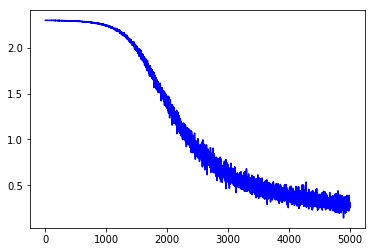

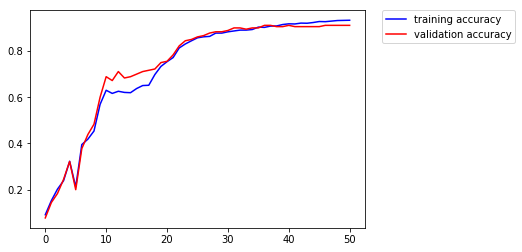

In [9]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

digits = load_digits()
x_, y_ = digits.data, digits.target

# do some data preprocessing
y_one_hot = np.zeros((len(y_), 10))
y_one_hot[np.arange(len(y_)), y_] = 1

x_ = x_ / x_.max() # normailze it to 0 - 1

# do train_test split
x_train, x_test, y_train, y_test = train_test_split(x_, y_one_hot, test_size = 0.1, stratify = y_)

# define training settings ------------
train_loss_list = []
train_acc_list = []
test_acc_list = []

iters_num = 5001
train_size = x_train.shape[0] # numbers of training samples
bz = 100 # batch size
lr = 0.01 # learning rate

network = Two_layerNet_bp(input_size=64, hidden_size=64, output_size=10)

for i in tqdm(range(iters_num)):
    batch_mask = np.random.choice(train_size, bz)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]

    
    grad = network.gradient(x_batch, y_batch) # already contain a feed-forward processing in this step
    
    for key in ("w1", "b1", "w2", "b2"):
        network.params[key] -= lr * grad[key]
        
    this_loss = network.loss(x_batch, y_batch)
    train_loss_list.append(this_loss)
    
    if i % 100 == 0:
        # compute accuracy for every 50 updates
        train_acc = network.compute_acc(x_train, y_train)
        test_acc = network.compute_acc(x_test, y_test)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        #print("Train accuarcy, Test accuracy | " + str(train_acc) + ", " + str(test_acc))
        
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b-')
plt.show()

plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b-', label = 'training accuracy')
plt.plot(np.arange(len(test_acc_list)), test_acc_list, 'r-', label = 'validation accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [0]:
# Define other layer functions
class relu_layer():
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

class affine_layer():
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        self.dW =None
        self.db = None
        
    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        dx = dx.reshape(*self.original_x_shape)
        
        return dx
    
def softmax(x):
    if x.ndim == 2:
        x = x.T # Transpose it
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    return np.exp(x) / np.sum(np.exp(x))

# define cross_entropy
def cross_entropy(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class softmax_with_crossentropy():
    def __init__(self):
        self.loss = None
        self.y = None # softmax output
        self.t = None # target (ground-truth)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy(self.y, self.t)
        
        return self.loss
    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

In [0]:
from collections import OrderedDict # this is a built-in function -- dictionary with order

class Two_layerNet_bp:
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 weight_init_std = 0.01):
        self.params = {}
        self.params['w1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['w2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # build network
        self.layers = OrderedDict()
        self.layers['affine_1'] = affine_layer(self.params['w1'], self.params['b1'])
        self.layers['sigmoid_1'] = relu_layer()
        self.layers['affine_2'] = affine_layer(self.params['w2'], self.params['b2'])
        # output layer
        self.lastlayer = softmax_with_crossentropy()
        
    def predict(self, x):
        # forward
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    def loss(self, x, y_true):
        y_pred = self.predict(x)
        return self.lastlayer.forward(y_pred, y_true)
    
    def compute_acc(self, x, y_true):
        y_pred = self.predict(x)
        # take argmax
        y_pred = y_pred.argmax(axis = 1) 
        y_true = y_true.argmax(axis = 1)
        
        acc = np.sum(y_pred == y_true) / len(y_true)
        return acc
    
    def gradient(self, x, t):
        # forward path
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastlayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # gradient init and setting
        grads = {}
        grads['w1'] = self.layers['affine_1'].dW
        grads['b1'] = self.layers['affine_1'].db
        grads['w2'] = self.layers['affine_2'].dW
        grads['b2'] = self.layers['affine_2'].db
        
        return grads

100%|██████████| 5001/5001 [00:01<00:00, 3122.88it/s]


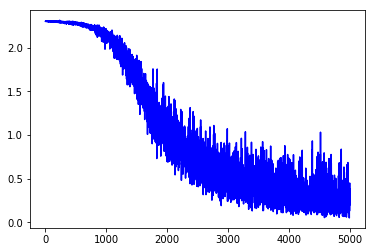

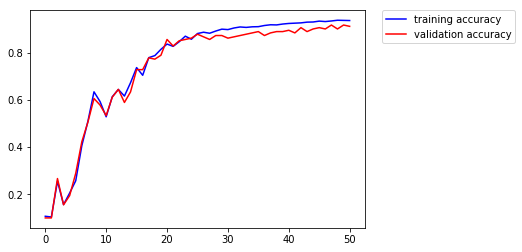

In [13]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tqdm import tqdm
digits = load_digits()

x_, y_ = digits.data, digits.target

# do some data preprocessing
y_one_hot = np.zeros((len(y_), 10))
y_one_hot[np.arange(len(y_)), y_] = 1

x_ = x_ / x_.max() # normailze it to 0 - 1

# do train_test split
x_train, x_test, y_train, y_test = train_test_split(x_, y_one_hot, test_size = 0.1, stratify = y_)

# define training settings ------------
train_loss_list = []
train_acc_list = []
test_acc_list = []

iters_num = 5001
train_size = x_train.shape[0] # numbers of training samples
bz = 10 # batch size
lr = 0.01 # learning rate

network = Two_layerNet_bp(input_size=64, hidden_size=128, output_size=10)

for i in tqdm(range(iters_num)):
    batch_mask = np.random.choice(train_size, bz)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(x_batch, y_batch) # already contain a feed-forward processing in this step
    
    for key in ("w1", "b1", "w2", "b2"):
        network.params[key] -= lr * grad[key]
        
    this_loss = network.loss(x_batch, y_batch)
    train_loss_list.append(this_loss)
    
    if i % 100 == 0:
        # compute accuracy for every 50 updates
        train_acc = network.compute_acc(x_train, y_train)
        test_acc = network.compute_acc(x_test, y_test)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
#         print("Train accuarcy, Test accuracy | " + str(train_acc) + ", " + str(test_acc))
        
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b-')
plt.show()

plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b-', label = 'training accuracy')
plt.plot(np.arange(len(test_acc_list)), test_acc_list, 'r-', label = 'validation accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()